A short introduction to fast SPT modeling
-----------------------------------------

This notebook presents a short introduction to the modeling of fast single particle tracking datasets. 
The methodology, together with examples of biological relevance, can be found at:

> Hansen, Anders S., Iryna Pustova, Claudia Cattoglio, Robert Tjian, and Xavier Darzacq. “CTCF and Cohesin Regulate Chromatin Loop Stability with Distinct Dynamics.” bioRxiv, 2016, 093476.

This package includes several sample datasets, that will be used by this notebook. Make sure that they can be found by Python.

## 1. Loading of a dataset

To help us with basic and repeated tasks such as dataset loading, we created a small library, `fastSPT_tools` that contain several helper functions that we will use all across this tutorial. We thus need to import it by typing `import fastSPT_tools`.

One of the functions list the available datasets: `list_sample_datasets(path)`. Let's first see what datasets we can get. Then, we will use the `load_dataset(path, dataset_id, cells)` function to load the relevant dataset. This latter function can either load one single cell or a series of cells (identified by their id).

In [1]:
import sys
from tqdm.autonotebook import tqdm
sys.version

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

C:\Users\andre\Programs\Miniconda\envs\spoton\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import lmfit

#sys.path.append(r'C:\Users\andre\Documents\Spot-On-cli')

import fastspt as fs
from fastspt import fit, tools, plot, readers, matimport, tracklen
%load_ext autoreload

%autoreload 2

print("Using fastspt version {}".format(fs.__version__))

import logging
logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

Using fastspt version 16.4


In [3]:
import os
os.getcwd()

'C:\\Users\\andre\\Documents\\Spot-On-cli'

In [4]:
path_wt = "datasets/20190503-eColi-PBP2-PAmCherry/"
path_oe = r"Z:\Andrey\fromGizem\2019-04-18-PBP2-tracks\PBP2OverExpforAndrey.mat"


In [5]:
#cell = readers.read_trackmate_xml(xml_path)
#reps = [cell]
data_path = path_wt

In [6]:
from glob import glob

In [7]:
# Specify folder location and search for .mat files
folder = r"datasets/2019-04-18-PBP2-tracks/"

data_paths = glob(folder + "*.mat")

In [8]:
# List found files
data_paths

['datasets/2019-04-18-PBP2-tracks\\A22inliq30forAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks\\deltaPBP1aforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks\\PBP2OverExpforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks\\RodZdepl12hforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks\\RodZforAndrey.mat',
 'datasets/2019-04-18-PBP2-tracks\\WTforAndrey.mat']

In [9]:
# select one
data_path = data_paths[5]
data_path

'datasets/2019-04-18-PBP2-tracks\\WTforAndrey.mat'

In [10]:
# Expected format is Replicate.acquisition.[x, y, frame, track_id]
all_exp = matimport.read_gizem_mat(data_path)
print(f'Discovered {len(all_exp)} replicates, with {[len(acq) for acq in all_exp]} experiments, each experiment contains {len(all_exp[0][0][0])} columns')

Discovered 6 replicates, with [5, 7, 5, 6, 5, 7] experiments, each experiment contains 4 columns


In [11]:
# Next, you need to choose, how to concatenate the datasets
concatenation_modes = {
    'all_together': matimport.concat_all,
    'by_replicates': matimport.concat_reps
}

In [12]:
# Let's concatenate by replicates and specify exposure time and pixel size (if your data in pixels)

howto_concatenate = 'by_replicates'

pixel_size_um = 0.075
exposure_ms = 60

if all_exp:
    reps = concatenation_modes[howto_concatenate](all_exp,
                                                  exposure_ms=exposure_ms,
                                                  pixel_size_um=pixel_size_um)
    print(f'Returning {len(reps)} replicates')

discovered 6 replicates containing [5, 7, 5, 6, 5, 7] acquisitions
Assembling tracks with minimal length 3, using exposure 60 ms and px size 0.075 µm


114  tracks 
389  tracks 
186  tracks 
316  tracks 
415  tracks 
Replicate 1: Total 1420 tracks


547  tracks 
505  tracks 
535  tracks 
195  tracks 
507  tracks 
473  tracks 
546  tracks 
Replicate 2: Total 3308 tracks


227  tracks 
443  tracks 
318  tracks 
229  tracks 
139  tracks 
Replicate 3: Total 1356 tracks


452  tracks 
287  tracks 
396  tracks 
476  tracks 
461  tracks 
461  tracks 
Replicate 4: Total 2533 tracks


882  tracks 
736  tracks 
672  tracks 
782  tracks 
734  tracks 
Replicate 5: Total 3806 tracks


402  tracks 
373  tracks 
332  tracks 
435  tracks 
469  tracks 
416  tracks 
522  tracks 
Replicate 6: Total 2949 tracks

Returning 6 replicates


In [13]:
# Alternatevely, we can concatenate all datasets:

howto_concatenate = 'all_together'

pixel_size_um = 0.075
exposure_ms = 60

if all_exp:
    reps = concatenation_modes[howto_concatenate](all_exp,
                                                  exposure_ms=exposure_ms,
                                                  pixel_size_um=pixel_size_um)
    
    print(f'Returning {len(reps)} replicates')

discovered 6 replicates containing [5, 7, 5, 6, 5, 7] acquisitions
Assembling tracks with minimal length 3, using exposure 60 ms and px size 0.075 µm


114  tracks 
389  tracks 
186  tracks 
316  tracks 
415  tracks 


547  tracks 
505  tracks 
535  tracks 
195  tracks 
507  tracks 
473  tracks 
546  tracks 


227  tracks 
443  tracks 
318  tracks 
229  tracks 
139  tracks 


452  tracks 
287  tracks 
396  tracks 
476  tracks 
461  tracks 
461  tracks 


882  tracks 
736  tracks 
672  tracks 
782  tracks 
734  tracks 


402  tracks 
373  tracks 
332  tracks 
435  tracks 
469  tracks 
416  tracks 
522  tracks 

Total 15372 tracks
Returning 1 replicates


# 2. Track lengths analysis

15372 tracks, 85639 localizations
Fit result: 21414.86 * e^(-x/2.07) + 129.00


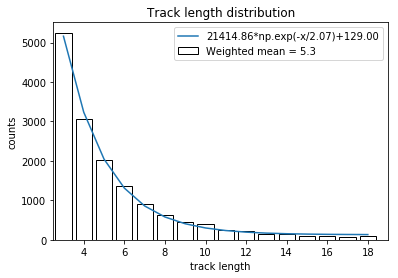

In [14]:
for rep in reps:
    tracklen.get_track_lengths_dist(rep, plot=True)

## 3. Fitting of the jump lengths distribution to the model (2 states)


Number of frames: 1000.0, number of localizations: 85639
Computation of jump lengths performed in 2.59s
Fitting 2 states
Improved fit on iteration 1
Improved error is 2.1914261401971726e-06
Name        Value      Min      Max   Stderr
D_bound  2.776e-19        0    0.005     None
D_free    0.04068     0.02      0.1     None
F_bound    0.2349        0        1     None
sigma     0.02166    0.005      0.1     None
None


C:\Users\andre\Documents\Spot-On-cli\fastspt\fit.py:662: RuntimeWarning: invalid value encountered in true_divide
  norm_y[i,:] = y[i,:]/y[i,:].sum()


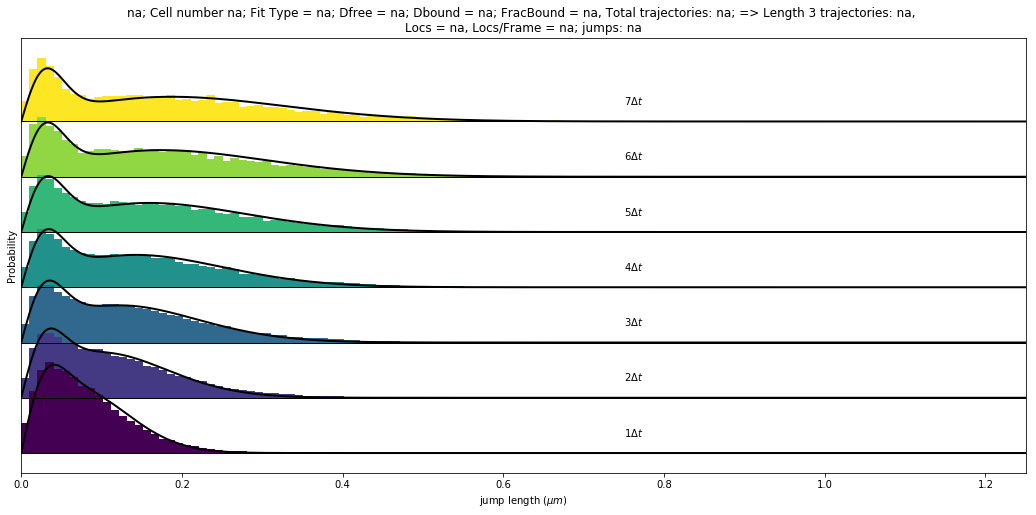

In [15]:
## Generate a dictionary of parameters
fit_params = dict(states=2,
                 iterations=1,
                 CDF=False,
                 CDF1 = True,
                 Frac_Bound = [0, 1],
                 D_Free = [0.02, 0.1],
                 D_Med = [0.005, 0.1],
                 D_Bound = [0.0, 0.005],
                 sigma = 0.02,
                 sigma_bound = [0.005, 0.1],
                 fit_sigma=True,
                 dT=0.06,
                 dZ=0.7,
                 a=0.15716,
                 b=0.20811,
                 useZcorr=False,
                 plot_hist=False,
                 plot_result=True) 


def my_fit(rep):
    
    cell_spt = readers.to_fastSPT(rep, from_json=False)
    fit_result = tools.auto_fit(cell_spt,
                                fit_params=fit_params)
    return fit_result

reps_fits = list(map(my_fit, reps))


In [16]:
#get stats
fit_stats = pd.DataFrame(columns=list(reps_fits[0].best_values.keys()) + ['chi2', 'num_tracks'])

for i, fit_result in enumerate(reps_fits):
    #name = data_paths[i].split("\\")[-2]
    name = f'rep {i+1}'
    fit_stats.loc[f'{name}'] = list(fit_result.best_values.values()) + [fit_result.chisqr, len(reps[i])]

fit_stats.loc['mean'] = fit_stats.mean(axis=0)
fit_stats.loc['std'] = fit_stats.std(axis=0)

#fit_stats.to_json(folder + '\stats.json')

fit_stats
#fit_stats.to_excel(path_oe + '.stats.xls')

,D_free,D_bound,F_bound,sigma,chi2,num_tracks
rep 1,0.040677,2.775558e-19,0.234897,0.021655,0.001931,15372.0
mean,0.040677,2.775558e-19,0.234897,0.021655,0.001931,15372.0
std,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.0


In [97]:
# remove bad fits
stats_filtered = fit_stats[fit_stats.chi2 < 0.01]
stats_filtered.to_json(folder + '\stats_chi2_better_than_0.01.json')
stats_filtered

,D_free,D_bound,F_bound,sigma,chi2,num_tracks
"['FOV1', 'movie_Ard_trig_v1.0_exp_60ms_561_50W_30ms_405_12.5mW_0.8ms_1']",0.061961,3.581161e-04,0.283051,0.047220,0.004957,1910.000000
"['FOV5', 'movie_continuos_exp_60ms_561_50W_405_12.5mW_1']",0.100000,7.438494e-17,0.235892,0.054208,0.005529,16449.000000
"['FOV7', 'movie_continuos_exp_60ms_561_50W_405_12.5mW_1']",0.068401,1.004699e-03,0.290912,0.049450,0.001203,9115.000000
mean,0.078304,3.407038e-04,0.366257,0.046612,0.007740,7115.500000
std,0.014634,4.102898e-04,0.168127,0.006856,0.006861,6240.106349


In [55]:
import json

In [58]:
json.dump(fit_params, open(folder + '\params.json', 'x'))

In [16]:
pd.read_json(r"Z:/Andrey/fromGizem/2019-04-18-PBP2-tracks/PBP2OverExpforAndrey.mat.stats.json",)

,D_fast,D_med,D_bound,F_fast,F_bound,sigma,chi2
mean,0.036449,0.011052,1.067581e-04,0.547984,0.123352,0.019759,0.001334
rep 1,0.036826,0.010664,1.053494e-04,0.521843,0.128585,0.019831,0.001504
rep 2,0.041200,0.015000,2.149249e-04,0.467069,0.124263,0.020219,0.001203
rep 3,0.031321,0.007492,7.549517e-17,0.655040,0.117209,0.019227,0.001295
std,0.004042,0.003078,8.774840e-05,0.078933,0.004689,0.000408,0.000126
